In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import tensorflow as tf
from utils.preprocessing import *
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior() # enables np methods on tensors

In [2]:
testing_dir = '../data/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
training_dir_base = f'../data/C-NMC_Leukemia/training_data/'
fold_0_all_path = 'fold_0/all'
fold_0_hem_path = 'fold_0/hem'

In [9]:
### The code for this lives in notebooks.utils.preprocessing
### Get grayscale images as tensors, and labels for both classes
img_train_cancer = get_gray_images(training_dir_base+fold_0_all_path)
img_train_healthy = get_gray_images(training_dir_base+fold_0_hem_path)
train_health_labels = [0 for _ in range(len(img_train_healthy))]
train_cancer_labels = [1 for _ in range(len(img_train_cancer))]

## Random Forests

In [6]:
def randomForestAccuracy(img_cancer, img_healthy, labels_healthy, labels_cancer, nest=100, mssplit=2, mdepth=None, rstate=100):
    ### For random forests, X is our combined image set and y is our combined label set.
    X =  np.array(img_cancer + img_healthy)
    y = np.array(labels_cancer + labels_healthy)

    ### train-test-split our data, and initialize the forest.
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=100)

    forest = RandomForestClassifier(n_estimators=nest, random_state=rstate, min_samples_split=mssplit, max_depth=100)

    ### The random forests algorithm expects 2 dimensional data at the most.
    ### We can accomplish this on our 4-dimensional data by multiplying the last 3 dimensions together to flatten the data
    X_shape = X_train.shape
    X_tshape = X_test.shape
    X_train = X_train.reshape(X_shape[0], X_shape[1] * X_shape[2] * X_shape[3])
    X_test = X_test.reshape(X_tshape[0], X_tshape[1] * X_tshape[2] * X_tshape[3])

    ### Fit the random forest, try it on the test data, and assess the model's accuracy
    forest.fit(X_train,y_train)
    predictions = forest.predict(X_test)
    return metrics.accuracy_score(y_test, predictions)

In [7]:
accuracy_original = randomForestAccuracy(img_train_cancer, img_train_healthy, train_health_labels, train_cancer_labels)

In [8]:
### Random forests, color
### We will repeat the steps above, with color images instead.
img_train_cancer = get_gray_images(training_dir_base+fold_0_all_path, 128)
img_train_healthy = get_gray_images(training_dir_base+fold_0_hem_path, 128)

In [9]:
accuracy_128 = randomForestAccuracy(img_train_cancer, img_train_healthy, train_health_labels, train_cancer_labels)

In [10]:
### I find that there is a negligible (0.4%) difference between full size and 128x128 downscaled images.
### Because downscaled images process faster, I will use those
print(accuracy_original)
print(accuracy_128)

0.8593012275731823
0.8630783758262511


In [11]:
### Assemble combinations of hyperparameters for tuning.
from itertools import product
_n_estimators = [10, 50, 100]
_min_samples_split = [2, 5, 10]
_max_depth = [10, 100, None]
_random_state = [50, 100, 256]
list_of_lists = [_n_estimators, _min_samples_split, _max_depth, _random_state]
all_combinations = list(product(*list_of_lists))

In [12]:
### Find the highest accuracy combination of hyperparameters.
max_accuracy = -1
max_accuracy_params = []
for combination in all_combinations:
    accuracy = randomForestAccuracy(img_train_cancer, img_train_healthy, train_health_labels, train_cancer_labels, 
                                    nest=combination[0], mssplit=combination[1], mdepth=combination[2], rstate=combination[3])
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_accuracy_params = combination

In [13]:
print(max_accuracy)
print(max_accuracy_params)

0.8649669499527857
(100, 10, 10, 100)


In [ ]:
# Perceptron

In [3]:
hsvImages = get_hsv_images(training_dir_base+fold_0_all_path)
saturatedImages = get_saturated_images(training_dir_base+fold_0_all_path)


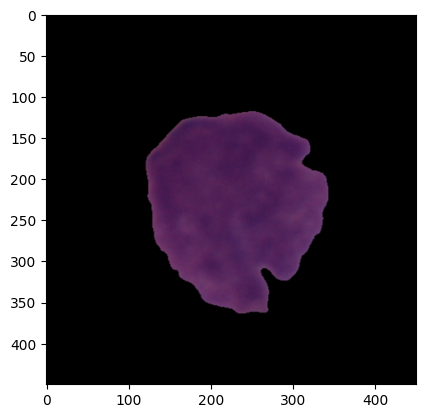

In [4]:

plt.imshow(saturatedImages[2].astype('uint8'))
